# Overview

## Importing Packages And Reading in Data

In [1]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV,\
      RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,\
    precision_score, recall_score, accuracy_score, f1_score, roc_auc_score,\
    RocCurveDisplay
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from scipy import stats as stats
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
## Enabling decision trees to be displayed as a diagram
set_config(display='diagram')

In [3]:
## Reading in data from CSV and seperating into features, X, and target, y
X_init = pd.read_csv('Data/training_set_features.csv', index_col=0)
y_init = pd.read_csv('Data/training_set_labels.csv', index_col=0)

## Data Exploration

In [4]:
X_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [7]:
# Assessing the number of missing values from each column for X
(X_init.isna().sum()/len(X_init)).sort_values(ascending=False)

employment_occupation          0.504362
employment_industry            0.499120
health_insurance               0.459580
income_poverty                 0.165612
doctor_recc_h1n1               0.080878
doctor_recc_seasonal           0.080878
rent_or_own                    0.076459
employment_status              0.054780
marital_status                 0.052720
education                      0.052683
chronic_med_condition          0.036358
child_under_6_months           0.030704
health_worker                  0.030104
opinion_seas_sick_from_vacc    0.020107
opinion_seas_risk              0.019246
opinion_seas_vacc_effective    0.017299
opinion_h1n1_sick_from_vacc    0.014790
opinion_h1n1_vacc_effective    0.014640
opinion_h1n1_risk              0.014528
household_children             0.009323
household_adults               0.009323
behavioral_avoidance           0.007788
behavioral_touch_face          0.004793
h1n1_knowledge                 0.004343
h1n1_concern                   0.003445


In [9]:
# Assessing the number of missing values from each column for y
y_init.isna().sum()

h1n1_vaccine        0
seasonal_vaccine    0
dtype: int64

In [13]:
#checking target distributions
y_init['h1n1_vaccine'].value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [14]:
# Checking target distributions
y_init['seasonal_vaccine'].value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

## Data Preparation

In [6]:
# dropping columns with over 25% data missing
X_drop = X_init.drop(['employment_occupation', 'employment_industry', 'health_insurance'], axis=1)

In [16]:
# dropping h1n1 target to create binary target
# Target was selected as it is the most balanced
y_drop = y_init.drop('h1n1_vaccine', axis=1)

In [17]:
X_drop.corrwith(y_drop['seasonal_vaccine']).sort_values(ascending=False)

opinion_seas_risk              0.390106
doctor_recc_seasonal           0.369190
opinion_seas_vacc_effective    0.361875
opinion_h1n1_risk              0.216625
opinion_h1n1_vacc_effective    0.205072
doctor_recc_h1n1               0.198607
chronic_med_condition          0.170174
h1n1_concern                   0.154828
health_worker                  0.127311
behavioral_touch_face          0.120228
h1n1_knowledge                 0.120152
behavioral_wash_hands          0.112414
behavioral_avoidance           0.076395
behavioral_large_gatherings    0.064025
behavioral_outside_home        0.053509
behavioral_face_mask           0.050083
opinion_h1n1_sick_from_vacc    0.027404
child_under_6_months           0.012097
behavioral_antiviral_meds      0.006277
opinion_seas_sick_from_vacc   -0.061510
household_adults              -0.064840
household_children            -0.114614
dtype: float64

In [19]:
#Splitting data using standard 80/20 train, test split to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X_drop, y_drop, random_state=50)

## Transformation Pipeline Construction

In [20]:
# Numerical pipeline created to handle missing values and then scale the data.
# Median was used to minimize the impact of outliersa compared to mean.
numerical_pipeline = Pipeline(steps=[
    ('impute_nums', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
#Categorical pipeline to handle missing values and encode any missing values
categorical_pipeline = Pipeline(steps=[
    ('cat_impute', SimpleImputer(strategy='most_frequent')),
    ('encode', OrdinalEncoder())])

# ColumnTransformer allows us to selective apply these pipelines
# to specific columns in the same dataset. Here object for categorical
# and numbers for numerical predictors.
# Make column selector handles the splicing for us.
trans = ColumnTransformer(transformers=[
     ('numerical', numerical_pipeline, make_column_selector(dtype_include=np.number)),
     ('categorical', categorical_pipeline, make_column_selector(dtype_include=object))     
])

## First Simple Model

In [21]:
# First model is a decision tree
# This was selected to help with important feature selection
# Max_depth of 2 specified to reduce overfitting
simple_model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('tree', DecisionTreeClassifier(max_depth=2, random_state=50))
    ])

In [22]:
# Fitting and transforming data with visualization print out
simple_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('tree', DecisionTreeClassifier(max_depth=2, random_state=50))])

In [23]:
simple_model_pipe.score(X_train, y_train)

0.7220169745381927

In [25]:
# Not overfitting as test and train are not massively different values
simple_model_pipe.score(X_test, y_test)

0.7158903699266137

In [26]:
# First Simple Predicted Values
simple_preds = simple_model_pipe.predict(X_test)

In [27]:
# Function to display all metric data from preds
def ScoreDisplay(preds):
    print(f'This is our f1 score: {f1_score(y_test, preds)}')
    print(f'This is our roc-auc score: {roc_auc_score(y_test, preds)}')
    print(f'This is our precision score: {precision_score(y_test, preds)}')
    print(f'This is our recall score: {recall_score(y_test, preds)}')
    print(f'This is our accuracy: {accuracy_score(y_test, preds)}')

In [29]:
ScoreDisplay(simple_preds)

This is our f1 score: 0.7136603773584906
This is our roc-auc score: 0.7176303623769451
This is our precision score: 0.6812680115273775
This is our recall score: 0.7492868462757528
This is our accuracy: 0.7158903699266137


## Additional Test Models

In [30]:
#finding column order post pipeline transformation
num_col = make_column_selector(dtype_include=np.number)(X_train)
cat_col = make_column_selector(dtype_include=object)(X_train)
cols = num_col+cat_col

In [31]:
# Finding most important features according to decision tree
simple_importance = simple_model_pipe.named_steps['tree'].feature_importances_
pd.Series(simple_importance, index=cols).sort_values(ascending=False)

opinion_seas_vacc_effective    0.591166
doctor_recc_seasonal           0.408834
h1n1_concern                   0.000000
hhs_geo_region                 0.000000
employment_status              0.000000
rent_or_own                    0.000000
marital_status                 0.000000
income_poverty                 0.000000
sex                            0.000000
race                           0.000000
education                      0.000000
age_group                      0.000000
household_children             0.000000
household_adults               0.000000
opinion_seas_sick_from_vacc    0.000000
opinion_seas_risk              0.000000
opinion_h1n1_sick_from_vacc    0.000000
h1n1_knowledge                 0.000000
opinion_h1n1_risk              0.000000
opinion_h1n1_vacc_effective    0.000000
health_worker                  0.000000
child_under_6_months           0.000000
chronic_med_condition          0.000000
doctor_recc_h1n1               0.000000
behavioral_touch_face          0.000000


In [32]:
# Creating Logistic Regression Model Next
# Selected for simplicity and classification power
# Previous transformatin pipeline used
log_model_pipe = Pipeline(steps=[
    ('trans', trans), ## need to drop out unused columns from the pipeline
    ('log', LogisticRegression(random_state=50))
    ])

In [33]:
# using features identified above for analysis
log_model_pipe.fit(X_train[['opinion_seas_vacc_effective', 'doctor_recc_seasonal']], y_train)

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('log', LogisticRegression(random_state=50))])

In [34]:
log_model_pipe.score(X_train[['opinion_seas_vacc_effective', 'doctor_recc_seasonal']], y_train)

0.7290564153769346

In [36]:
# No sign of overfitting
log_model_pipe.score(X_test[['opinion_seas_vacc_effective', 'doctor_recc_seasonal']], y_test)

0.7259248165343717

In [38]:
## Precision Score has increased but not quite where we'd like
simplog_preds = log_model_pipe.predict(X_test[['opinion_seas_vacc_effective', 'doctor_recc_seasonal']])
ScoreDisplay(simplog_preds)

This is our f1 score: 0.7166305357695881
This is our roc-auc score: 0.7263163128571055
This is our precision score: 0.7005752346351801
This is our recall score: 0.7334389857369256
This is our accuracy: 0.7259248165343717


In [39]:
# Creating Transform Dataset using ColumnTransformer from pipelines
X_train_trans = pd.DataFrame(trans.fit_transform(X_train),
             columns=cols,
             index=X_train.index)

In [42]:
#Checking for Multicolinearity
X_train_trans.corrwith(y_train['seasonal_vaccine']).sort_values(ascending=False)

opinion_seas_risk              0.386732
doctor_recc_seasonal           0.367122
opinion_seas_vacc_effective    0.356234
age_group                      0.280576
opinion_h1n1_risk              0.218364
opinion_h1n1_vacc_effective    0.203845
doctor_recc_h1n1               0.202799
chronic_med_condition          0.176750
h1n1_concern                   0.151502
health_worker                  0.127277
h1n1_knowledge                 0.120049
behavioral_touch_face          0.119534
behavioral_wash_hands          0.108003
race                           0.099749
behavioral_avoidance           0.077706
employment_status              0.062044
behavioral_large_gatherings    0.061561
behavioral_outside_home        0.053363
behavioral_face_mask           0.051062
opinion_h1n1_sick_from_vacc    0.024881
education                      0.022890
child_under_6_months           0.015628
behavioral_antiviral_meds      0.001990
census_msa                    -0.013233
hhs_geo_region                -0.020212


In [43]:
X_train_trans.corr()['opinion_seas_vacc_effective'].sort_values(ascending=False)

opinion_seas_vacc_effective    1.000000
opinion_h1n1_vacc_effective    0.475409
opinion_seas_risk              0.344946
h1n1_concern                   0.231543
opinion_h1n1_risk              0.225527
doctor_recc_seasonal           0.172938
behavioral_wash_hands          0.139549
age_group                      0.131859
behavioral_avoidance           0.115372
behavioral_touch_face          0.106723
doctor_recc_h1n1               0.106182
chronic_med_condition          0.092186
h1n1_knowledge                 0.088002
behavioral_large_gatherings    0.079590
opinion_h1n1_sick_from_vacc    0.078400
behavioral_outside_home        0.067623
race                           0.061741
employment_status              0.051741
health_worker                  0.034140
behavioral_face_mask           0.033189
child_under_6_months           0.011288
behavioral_antiviral_meds      0.010115
education                      0.000554
income_poverty                -0.010229
census_msa                    -0.010507


In [45]:
#Fitting logistic regression on whole dataset
# Attempting to find additional powerful predictors
log_model_pipe.fit(X_train, y_train)

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('log', LogisticRegression(random_state=50))])

In [46]:
log_model_pipe.score(X_train, y_train)

0.7759860209685472

In [48]:
#No signs of overfitting
log_model_pipe.score(X_test, y_test)

0.7659128351055864

In [50]:
biglog_preds = log_model_pipe.predict(X_test)
ScoreDisplay(biglog_preds)

This is our f1 score: 0.7436444152862064
This is our roc-auc score: 0.7634447633215171
This is our precision score: 0.7705642420122366
This is our recall score: 0.7185419968304279
This is our accuracy: 0.7659128351055864


In [52]:
# finding additional strong predictors for logistic regression
pd.Series(log_model_pipe.named_steps['log'].coef_[0], index=cols).sort_values(ascending=False)

opinion_seas_risk              0.713229
doctor_recc_seasonal           0.680935
opinion_seas_vacc_effective    0.599357
age_group                      0.369784
health_worker                  0.250859
h1n1_knowledge                 0.106490
chronic_med_condition          0.105837
race                           0.104859
behavioral_touch_face          0.103943
opinion_h1n1_risk              0.070264
education                      0.058691
behavioral_wash_hands          0.025305
behavioral_antiviral_meds      0.022614
child_under_6_months           0.021100
behavioral_face_mask           0.015229
opinion_h1n1_vacc_effective    0.007466
employment_status              0.003864
sex                           -0.003282
behavioral_avoidance          -0.003302
h1n1_concern                  -0.004085
hhs_geo_region                -0.006643
income_poverty                -0.007883
behavioral_large_gatherings   -0.018002
behavioral_outside_home       -0.022032
household_children            -0.039170


In [53]:
# creating list of columns to use in regression
log_cols = ['opinion_seas_risk', 'doctor_recc_seasonal', 'opinion_seas_vacc_effective', \
            'age_group', 'health_worker', 'opinion_seas_sick_from_vacc']

In [54]:
log_model_pipe.fit(X_train[log_cols], y_train)

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('log', LogisticRegression(random_state=50))])

In [55]:
log_model_pipe.score(X_train[log_cols], y_train)

0.7710933599600599

In [56]:
log_model_pipe.score(X_test[log_cols], y_test)

0.7618691028905197

In [57]:
logtwo_preds = log_model_pipe.predict(X_test[log_cols])

In [58]:
## Accuracy has gone done <0.5% when only using 6 rather than 32 predictors
ScoreDisplay(logtwo_preds)

This is our f1 score: 0.7392587733683175
This is our roc-auc score: 0.7593970343532301
This is our precision score: 0.7658851512062521
This is our recall score: 0.7144215530903328
This is our accuracy: 0.7618691028905197


In [59]:
# Created a Random Forest model to test the efficacy of ensamble models
rfc_model_pipe = Pipeline(steps=[
    ('trans', trans),
    ('forest', RandomForestClassifier(max_depth=3, random_state=50, n_estimators=10))])

In [60]:
rfc_model_pipe.fit(X_train, y_train)

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('forest',
                 RandomForestClassifier(max_depth=3, n_estimators=10,
                                        random_state=50))])

In [61]:
rfc_model_pipe.score(X_train, y_train)

0.7439340988517225

In [62]:
# No sign of overfitting
rfc_model_pipe.score(X_test, y_test)

0.7359592631421297

In [63]:
rfc_preds = rfc_model_pipe.predict(X_test)

In [64]:
#Lower Accuracy and Precision compared to logistical regression 
ScoreDisplay(rfc_preds)

This is our f1 score: 0.7033484772000672
This is our roc-auc score: 0.7321288599349707
This is our precision score: 0.7496413199426112
This is our recall score: 0.6624405705229794
This is our accuracy: 0.7359592631421297


In [65]:
# Decided to use a grid search on the logistic regression model
# Trying different solvers, penalties, and penatly strength
log_cs_grid = {
    'log__penalty': ['log__', 'l1', 'l2', 'elasticnet', None],
    'log__C' : [0, 5, 10, 20, 50, 75, 100],
    'log__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    }

searchcv = GridSearchCV(estimator=log_model_pipe,
                        param_grid=log_cs_grid,
                        scoring='precision')

In [66]:
# Fitting and getting best parameters out of the model
searchcv.fit(X_train[log_cols], y_train)
searchcv.best_params_

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example 

{'log__C': 5, 'log__penalty': 'l1', 'log__solver': 'saga'}

In [80]:
# Trying randomized search to find values for continuous parameters
log_reg_grid = {'log__C': stats.uniform(loc=0, scale=10),
               'log__l1_ratio': stats.expon(scale=0.2),
               'log__penalty': ['log__', 'l1', 'l2', 'elasticnet', None],
               'log__solver': ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

rs = RandomizedSearchCV(estimator=log_model_pipe,
                        param_distributions=log_reg_grid,
                        scoring='precision',
                        random_state=50)

In [81]:
## Finding best parameters
rs.fit(X_train[log_cols], y_train)
rs.best_params_

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\DJ\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1476: UserWarning: l1_ra

{'log__C': 4.946016455380215,
 'log__l1_ratio': 0.05177567660045704,
 'log__penalty': 'l1',
 'log__solver': 'saga'}

## Final Model

In [106]:
# With hyperparameters confirmed for logistic regression model, final pipeline is as follows
# Cannot use l1_ratio as it only works with elasticnet penalty
# This would negatively impact the model so the parameter is omitted

final_pipe = Pipeline(steps=[
                                 ('trans', trans),
                                 ('log', LogisticRegression(C=5, penalty='l1', solver= 'saga', random_state=50))
                                 ])

In [107]:
final_pipe.fit(X_train[log_cols], y_train)

c:\Users\DJ\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('trans',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('impute_nums',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157DA76B20>),
                                                 ('categorical',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OrdinalEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002157D259F10>)])),
                ('log',
                 LogisticRegression(C=5, penalty='l1', random_state=50,
                                    solver='saga'))])

In [108]:
final_pipe.score(X_train[log_cols], y_train)

0.7710933599600599

In [109]:
final_pipe.score(X_test[log_cols], y_test)

0.7618691028905197

In [110]:
# Getting final predicted values
finallog_preds = final_pipe.predict(X_test[log_cols])

In [111]:
# Final Scores
ScoreDisplay(finallog_preds)

This is our f1 score: 0.7392587733683175
This is our roc-auc score: 0.7593970343532301
This is our precision score: 0.7658851512062521
This is our recall score: 0.7144215530903328
This is our accuracy: 0.7618691028905197


In [112]:
cross_val_score(final_pipe, X_train[log_cols], y_train['seasonal_vaccine'], scoring='precision').mean()

0.7717058384737966

In [113]:
final_coef = final_pipe.named_steps['log'].coef_

In [121]:
def logOddsPipelineConverter(data, colt):
    odds = []
    for item in data:
        for score in item:
            odds.append(np.exp(score))
    return pd.Series(odds, index=colt)

In [127]:
final_odds = logOddsPipelineConverter(final_coef, log_cols)
final_odds

opinion_seas_risk              2.104511
doctor_recc_seasonal           1.894827
opinion_seas_vacc_effective    1.853458
age_group                      1.326044
health_worker                  0.723932
opinion_seas_sick_from_vacc    1.509126
dtype: float64

In [123]:
final_int = final_pipe.named_steps['log'].intercept_

In [124]:
##chance vaccine if all predictors are 0
np.exp(final_int)/(1+np.exp(final_int))

array([0.25006248])

## Additional Exploration

In [117]:
cross_val_score(final_pipe, X_train[log_cols], y_train['seasonal_vaccine'], scoring='precision').mean()

0.7717058384737966

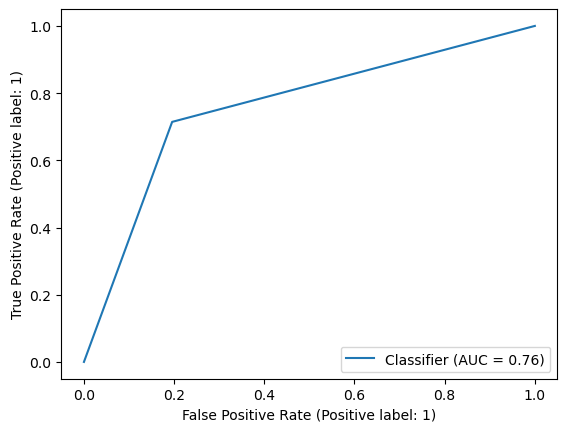

In [118]:
# Visualization of the ROC curve used in scoring this competition
RocCurveDisplay.from_predictions(y_test, finallog_preds)
plt.show()

## Final Interpretation

Our final model was a logistic regression including 6 of the 32 variables. These variables ('opinion_seas_risk','doctor_recc_seasonal','opinion_seas_vacc_effective','age_group','health_worker','opinion_seas_sick_from_vacc') were able to produce precision scores that were <1% less than the model including all variables. An increase in anyone of these variables will increase the odds that someone will get the vaccine. 

Precision was used as the metric of choice in this context. For our stakeholder, a public health firm attempting to increase vaccine adoption, false positives, or someone predicted to get the vaccine but doesn't, are far more impactful. The aim is to reduce the number of unvaccinated individuals. If we claim someone will not get vaccinated when they do, the community impact is arguably positive. As such, precision was our metric of choice. The ROC-AUC score was also looked into as this was competition standard. 